In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from hera_cal import io, redcal, abscal, utils, apply_cal
from hera_cal.datacontainer import DataContainer
import linsolve
from copy import deepcopy
import hera_sim
from hera_cal.utils import split_pol, split_bl
%matplotlib notebook

from hera_cal.version import construct_version_info
print 'hera_cal:\n', construct_version_info()
from hera_sim.version import construct_version_info
print '\nhera_sim:\n', construct_version_info()

hera_cal:
{'git_description': 'v2.0-662-g41a3278-dirty', 'version': '2.0', 'git_branch': 'phase-offset-solving', 'git_origin': 'https://github.com/HERA-Team/hera_cal.git', 'git_hash': '41a3278fcbde6b31341179ac6005e907f5c8ca02'}

hera_sim:
{'git_hash': '87abb985f5092cac32615d022b8be84c071b0596', 'version': '0.0.1', 'git_description': '87abb98', 'git_branch': 'master', 'git_origin': 'https://github.com/HERA-Team/hera_sim.git'}


# Generate Uncalibrated Data

In [2]:
hd = io.HERAData('randsrc_airybeam_Nsrc100_fullband.uvh5')
data, flags, nsamples = hd.read()

In [20]:
np.random.seed(22)
ants = sorted({ant: 0 for bl in data.keys() for ant in split_bl(bl)}.keys())
true_gains = hera_sim.sigchain.gen_gains(hd.freqs/1e9, ants, dly_rng=(-20, 20))
phase_offsets = {ant: 2 * np.pi * np.random.rand() for ant in true_gains.keys()}
true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * phase_offsets[ant])
              for ant, g in true_gains.items()}
apply_cal.calibrate_in_place(data, true_gains, gain_convention='multiply')
hd.update(data=data)
hd.write_uvh5('uncalibrated_randsrc_airybeam_Nsrc100_fullband.uvh5', clobber=True)

File exists; clobbering


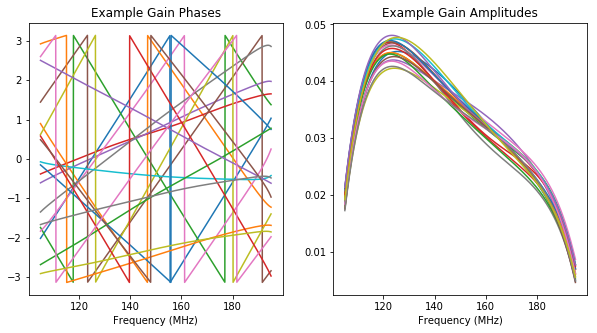

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
for ant in ants[::4]:
    ax[0].plot(hd.freqs[50:-50]/1e6, np.angle(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[0].set_title('Example Gain Phases')
    ax[0].set_xlabel('Frequency (MHz)')
    ax[1].plot(hd.freqs[50:-50]/1e6, np.abs(np.mean(true_gains[ant], axis=0))[50:-50])
    ax[1].set_title('Example Gain Amplitudes')
    ax[1].set_xlabel('Frequency (MHz)')
    

# Run Redcal

In [5]:
redcal.redcal_run('uncalibrated_randsrc_airybeam_Nsrc100_fullband.uvh5', flag_nchan_high=50, flag_nchan_low=50,
                  solar_horizon=90, clobber=True, ex_ants=[155, 156], verbose=True, ant_z_thresh=1e10);


Now running redundant calibration without antennas [155, 156] ...
Now calibrating ['xx'] polarization(s)...
    Now calibrating times 2458110.185232736 through 2458110.185729839 ...
Now calibrating ['yy'] polarization(s)...
    Now calibrating times 2458110.185232736 through 2458110.185729839 ...

Now saving firstcal gains to uncalibrated_randsrc_airybeam_Nsrc100_fullband.first.calfits
Now saving omnical gains to uncalibrated_randsrc_airybeam_Nsrc100_fullband.omni.calfits
Now saving omnical visibilities to uncalibrated_randsrc_airybeam_Nsrc100_fullband.omni_vis.uvh5
File exists; clobbering


# Run Abscal

In [6]:
abscal.post_redcal_abscal_run('uncalibrated_randsrc_airybeam_Nsrc100_fullband.uvh5',
                             'uncalibrated_randsrc_airybeam_Nsrc100_fullband.omni.calfits',
                             ['randsrc_airybeam_Nsrc100_fullband.uvh5'], clobber=True, verbose=True);



Now calibrating xx-polarization...

    Now calibrating times 2458110.185232736 through 2458110.185729839...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the dft algorithm


invalid value encountered in true_divide


...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.025267352306594253
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.0252520905981562e-08
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 0.38242736838492397
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 1.9649584781264962e-08


invalid value encountered in true_divide
invalid value encountered in true_divide




Now calibrating yy-polarization...

    Now calibrating times 2458110.185232736 through 2458110.185729839...
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_slope_lincal
...running linsolve
...finished linsolve
...configuring global_phase_slope_logcal for the dft algorithm
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 0.020944775691541413
...configuring global_phase_slope_logcal for the linfit algorithm
...running linsolve
...finished linsolve
global_phase_slope_logcal convergence criterion: 1.0110450100469533e-08
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
TT_phs_logcal convergence criterion: 0.11745443174128212
...configuring linsolve data for TT_phs_logcal
...

# Rephase to Evaluate Solutions

In [7]:
hc = io.HERACal('uncalibrated_randsrc_airybeam_Nsrc100_fullband.abs.calfits')
g, gf, q, tq = hc.read()

In [8]:
refant = {'Jxx': (0, 'Jxx'), 'Jyy': (0, 'Jyy')}
agr = {ant: g[ant] * np.abs(g[refant[ant[1]]]) / g[refant[ant[1]]] 
            for ant in g.keys()}
tgr = {ant: true_gains[ant] * np.abs(true_gains[refant[ant[1]]]) / true_gains[refant[ant[1]]] 
            for ant in true_gains.keys()}

In [9]:
for pol in ['Jxx', 'Jyy']:
    gain_errors = [agr[ant][~gf[ant]] - tgr[ant][~gf[ant]] for ant in tgr if ant[1] == pol]
    print '{} Mean Abs Gain Error: '.format(pol), np.mean(np.abs(gain_errors))
    

Jxx Mean Abs Gain Error:  5.927669999604534e-09
Jyy Mean Abs Gain Error:  6.053543005054603e-09
